# training.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import sys
sys.path.append("/home/jchishol/TRecNet")
sys.path.append("home/jchishol/")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool
import importlib
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from training_utilities import PlotLearning

import normalize
import shape_timesteps
import analysis

## Loading Files

In [2]:
# Jet type we want to use
#name = 'e+mjets_train'

# Dataset to train and test on
#dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_parton_'+name+'.h5','r')

# Numpy array of [max,mean] for each variable
#X_maxmean = np.load('X_maxmean_parton_'+name+'.npy')
#Y_maxmean = np.load('Y_maxmean_parton_'+name+'.npy')

# Data type we want to use
data_type = 'variables_ttbar_ljets_6j_train'

# Dataset to train and test on
dataset = h5py.File('/mnt/xrootdg/jchishol/mntuples_08_01_22/'+data_type+'.h5','r')

# Numpy dictionary of [max,mean] for each variable
X_maxmean_dic = np.load('/home/jchishol/TRecNet/X_maxmean_'+data_type+'.npy',allow_pickle=True).item()
Y_maxmean_dic = np.load('/home/jchishol/TRecNet/Y_maxmean_'+data_type+'.npy',allow_pickle=True).item()

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key and 'ttbar' not in key]
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(Y_maxmean)

[[ 2.42433750e+03  1.46267823e+02]
 [ 2.36265326e+03 -3.66642000e-01]
 [ 1.61712348e+03 -7.30951782e-01]
 [ 1.07022066e+01  6.54651605e-04]
 [ 2.43950391e+02  1.72247044e+02]
 [ 1.53045374e+03  9.90823212e+01]
 [ 1.45870581e+03 -1.66475415e-01]
 [ 1.28060168e+03 -3.46636355e-01]
 [ 8.92531300e+00  3.70313734e-04]
 [ 2.04917023e+02  8.01318359e+01]
 [ 1.75374163e+03  1.49843150e+02]
 [ 1.41141628e+03  4.59662159e-01]
 [ 1.74988845e+03  9.19522618e-01]
 [ 1.05103025e+01 -7.88349730e-04]
 [ 2.43951250e+02  1.72264233e+02]
 [ 1.54557300e+03  1.04858582e+02]
 [ 1.41250549e+03  4.19614762e-01]
 [ 1.48498035e+03  7.51959860e-01]
 [ 9.10289860e+00 -1.13270234e-03]
 [ 2.03822052e+02  8.01997147e+01]]


## Scale the Data

In [4]:
# Scales data set to be between -1 and 1, with a mean of 0
importlib.reload(normalize)
Scaler = normalize.Scale_variables(phi_keys,dataset,crop0)
X_total, X_names = Scaler.scale_arrays(dataset,X_keys,X_maxmean,crop0)
Y_total, Y_names = Scaler.scale_arrays(dataset,Y_keys, Y_maxmean,crop0)

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
# Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation
split = 70/85   # Gave 85% to train file, now want 70% for the actual training


# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(dataset,X_total, X_names, phi_keys,crop0,False,True)

# Split into training and validation data
trainX_jets, valX_jets, trainX_other, valX_other, trainY, valY = train_test_split(totalX_jets, totalX_other, Y_total, train_size=split)

print(trainY.shape)

(16874830, 20)


## Histograms of Scaled Input X and Y Variables

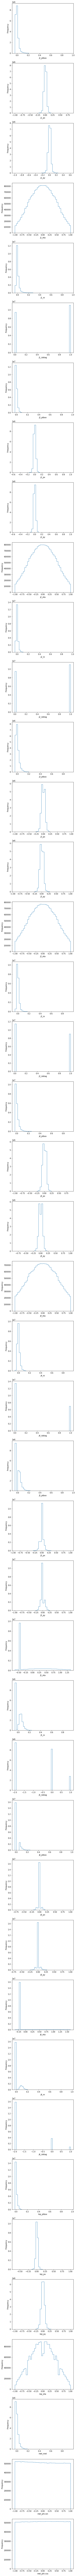

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

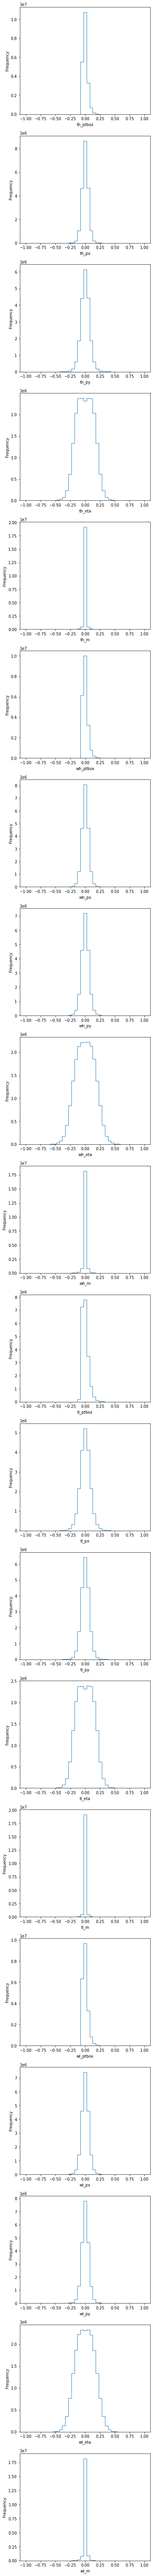

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
#keras.utils.plot_model(model,to_file='Model_Custom.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2023-01-25 16:37:30.630545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-01-25 16:37:30.630585: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-25 16:37:30.631220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Fit the Model 

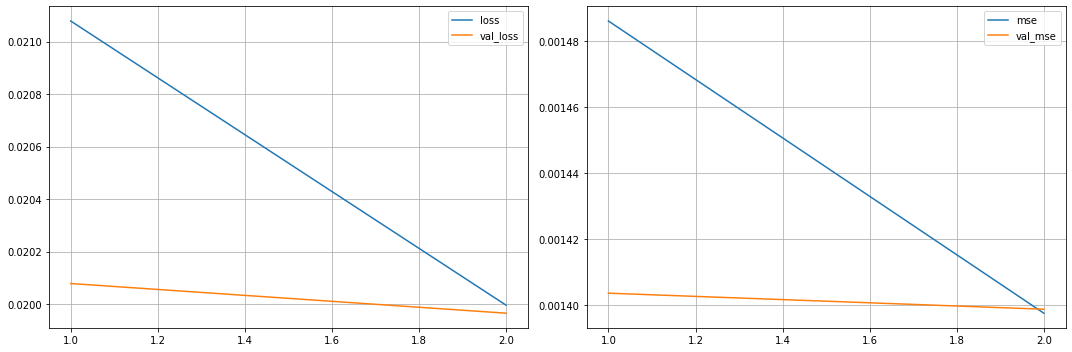

16875/16875 [==============================] - 272s 16ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0200 - val_mse: 0.0014
Epoch 3/256
13753/16875 [=======================>......] - ETA: 44s - loss: 0.0199 - mse: 0.0014

In [9]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
#clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)  # don't think we use this?
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

## Save the Model

In [10]:
model.save('Model_Custom_full_6j.keras')
np.save('trainHistory_Model_Custom_full_6j.npy',history.history)

In [11]:
model = keras.models.load_model('Model_Custom_full_6j.keras')
history = np.load('trainHistory_Model_Custom_full_6j.npy',allow_pickle='TRUE').item()

## Plot Training Stats 

In [12]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'TRecNet MSE Loss')

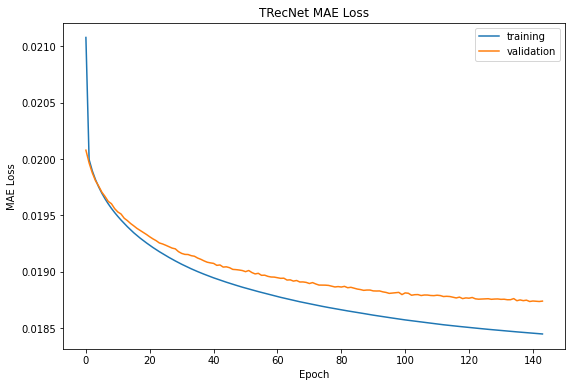

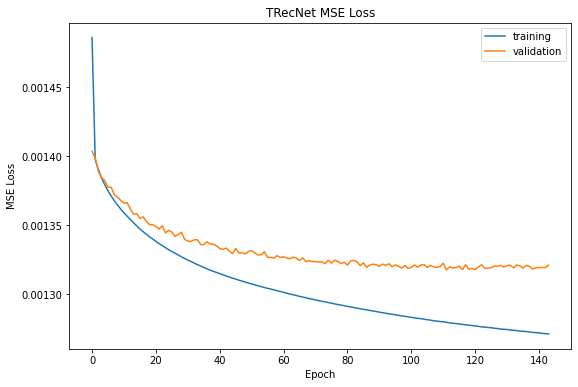

In [13]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.title('TRecNet MAE Loss')

plt.figure(figsize=(9,6))
plt.plot(history['mse'], label='training')
plt.plot(history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('TRecNet MSE Loss')

# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Validation Data

In [14]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

113002/113002 [==============================] - 452s 4ms/step


In [15]:
analysis.Analysis.save_errors(predictions_origscale,true_origscale,Y_keys,True,'Model_Custom_full_Errors')

## Training Scale Plots (Tao's Code)

In [16]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0013209799179088291
 
th_ptbox MSE, MAE :  0.0002951720 0.0113819859
th_px MSE, MAE :  0.0005540956 0.0137913931
th_py MSE, MAE :  0.0011816624 0.0200343257
th_eta MSE, MAE :  0.0039160256 0.0338219044
th_m MSE, MAE :  0.0005997693 0.0087432299
wh_ptbox MSE, MAE :  0.0005619355 0.0147192650
wh_px MSE, MAE :  0.0008512995 0.0169891360
wh_py MSE, MAE :  0.0011038519 0.0192734777
wh_eta MSE, MAE :  0.0065315466 0.0446999922
wh_m MSE, MAE :  0.0008583676 0.0127847286
tl_ptbox MSE, MAE :  0.0003935268 0.0140855596
tl_px MSE, MAE :  0.0007736692 0.0184993649
tl_py MSE, MAE :  0.0004981537 0.0148939438
tl_eta MSE, MAE :  0.0025992619 0.0331533630
tl_m MSE, MAE :  0.0006050866 0.0087682761
wl_ptbox MSE, MAE :  0.0002677113 0.0119477310
wl_px MSE, MAE :  0.0002676276 0.0120319652
wl_py MSE, MAE :  0.0002412852 0.0114478724
wl_eta MSE, MAE :  0.0034182506 0.0406911060
wl_m MSE, MAE :  0.0009012994 0.0130425932


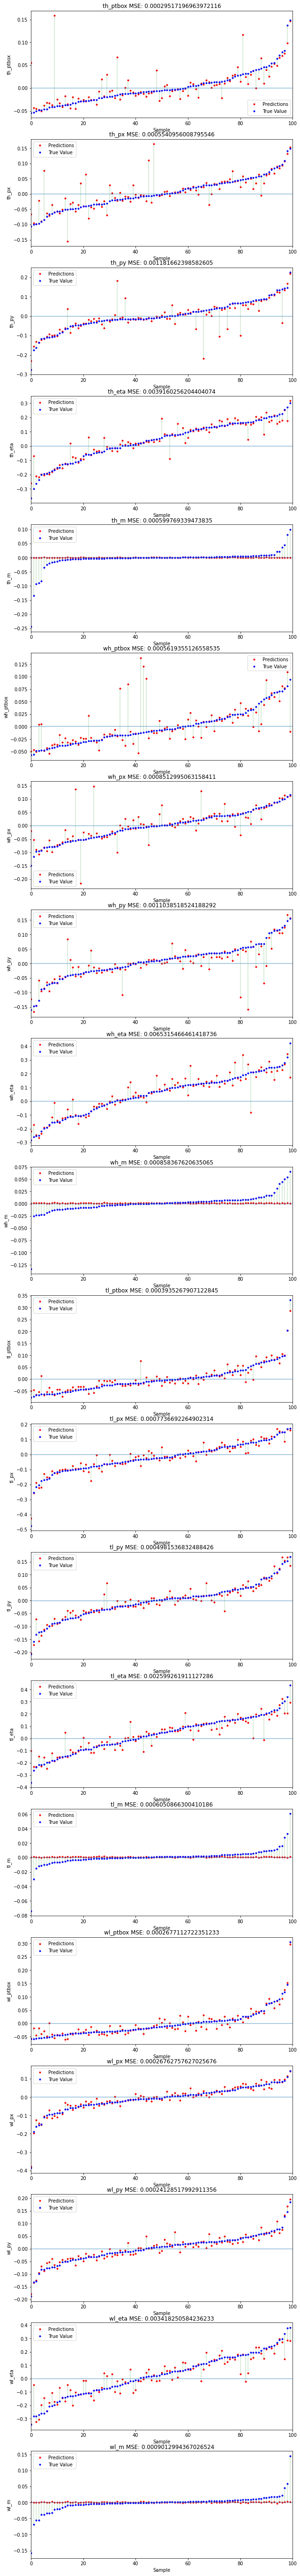

In [17]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

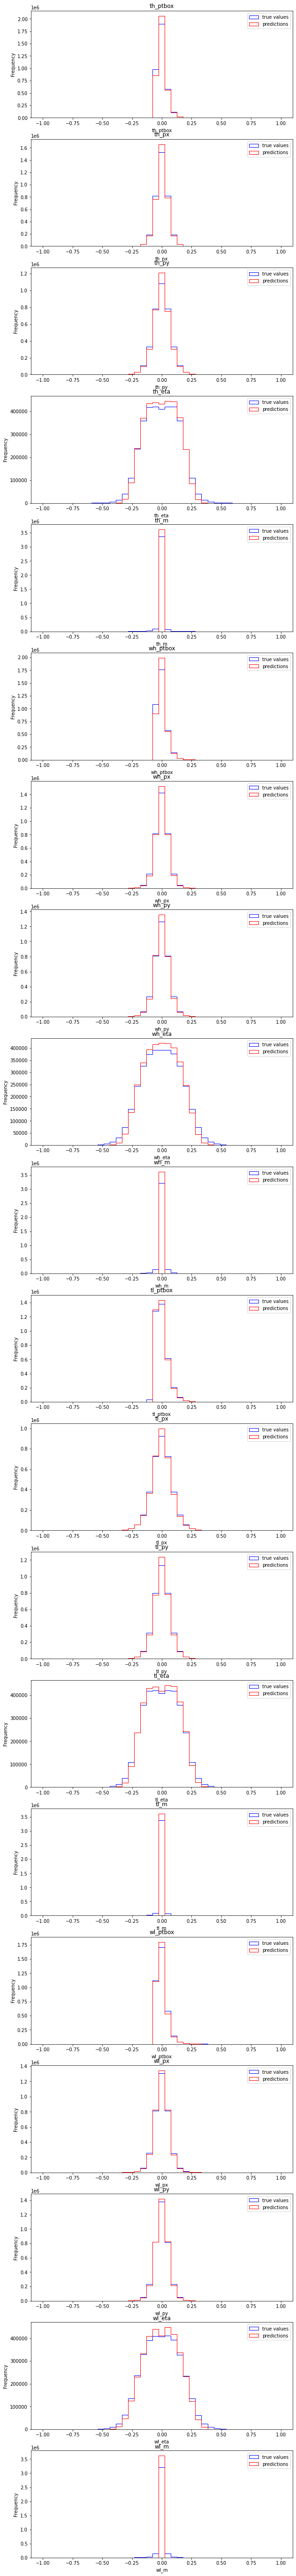

In [18]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

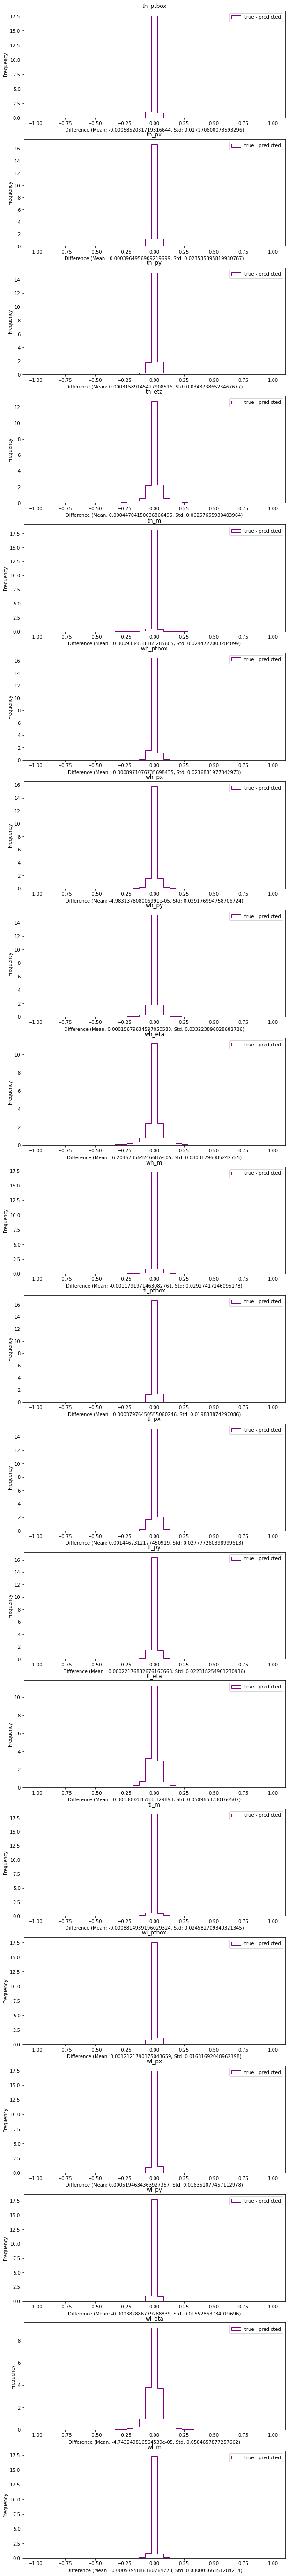

In [19]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

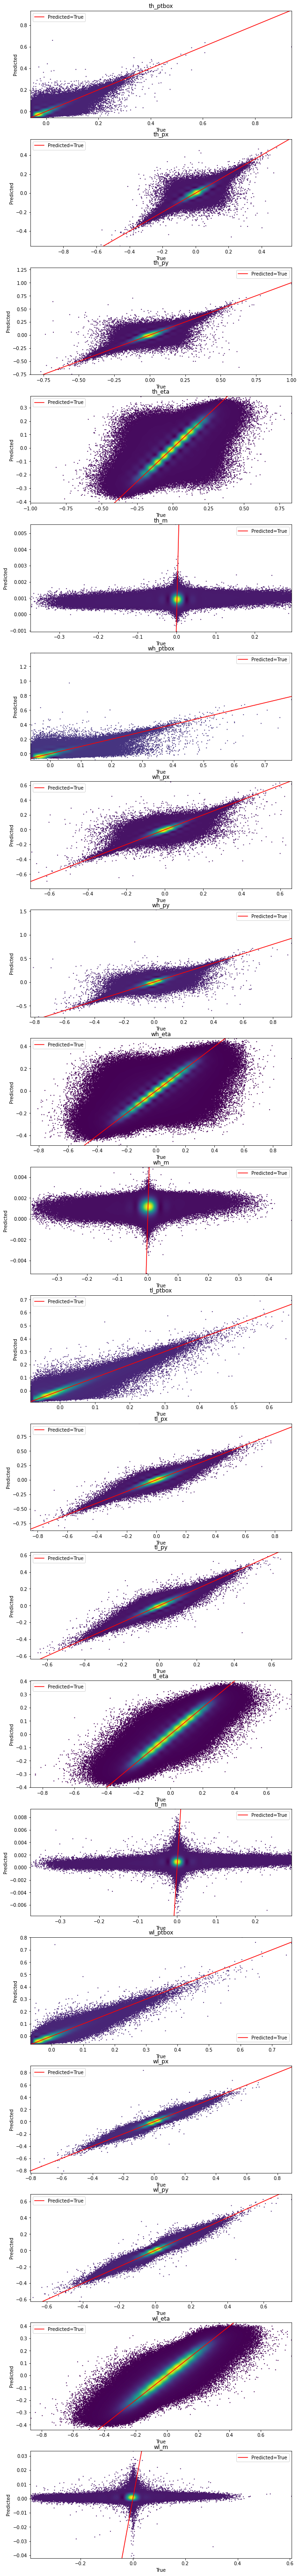

In [20]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [21]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 315.92713589776264
 
th_pt MSE, MAE :  1734.8473690805 27.5937753466
th_eta MSE, MAE :  0.4485307129 0.3619690086
th_phi MSE, MAE :  0.6576125160 0.4342634792
th_m MSE, MAE :  35.6933488301 2.1329143384
wh_pt MSE, MAE :  1316.2151654876 22.5271540319
wh_eta MSE, MAE :  0.5203109226 0.3989614217
wh_phi MSE, MAE :  0.6311448245 0.4406449916
wh_m MSE, MAE :  36.0437029077 2.6198085295
tl_pt MSE, MAE :  1210.3348097101 24.7024321635
tl_eta MSE, MAE :  0.2871312608 0.3484518753
tl_phi MSE, MAE :  0.3939098466 0.3271952801
tl_m MSE, MAE :  36.0100440332 2.1390319044
wl_pt MSE, MAE :  639.5075874354 18.4660904880
wl_eta MSE, MAE :  0.2832456876 0.3704070119
wl_phi MSE, MAE :  0.1857321787 0.2410015202
wl_m MSE, MAE :  37.4430690503 2.6583681028


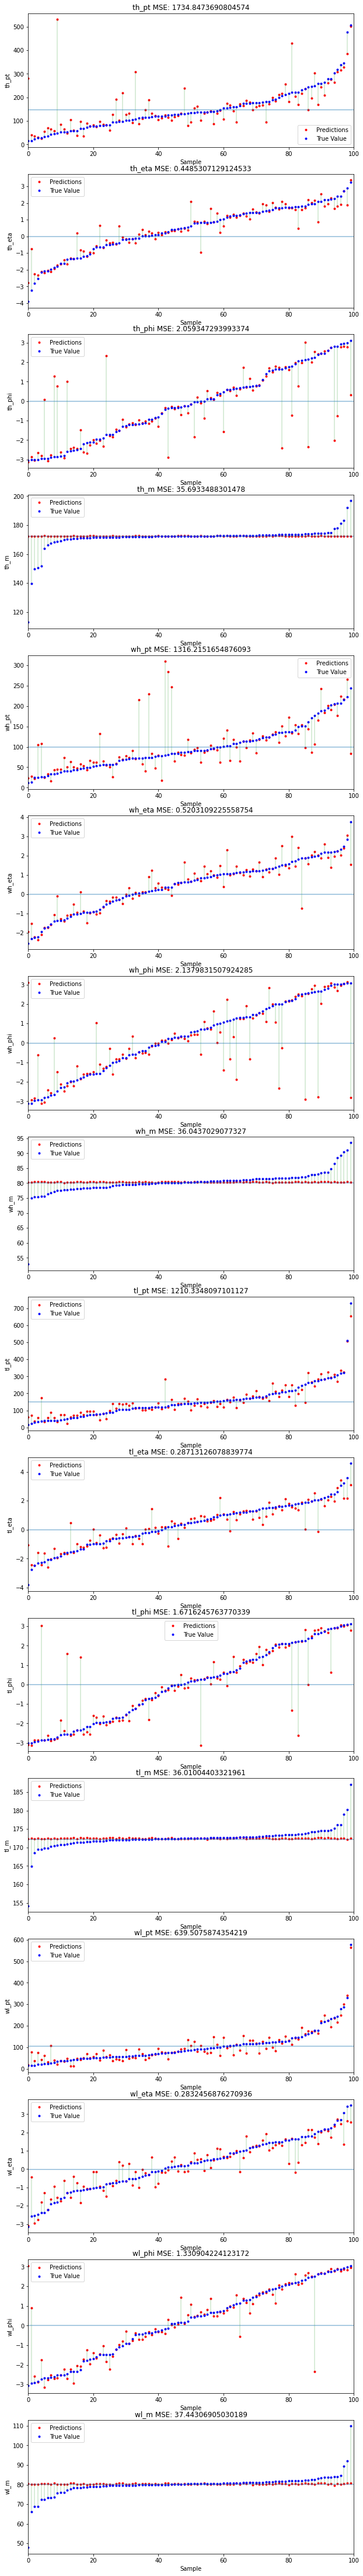

In [22]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

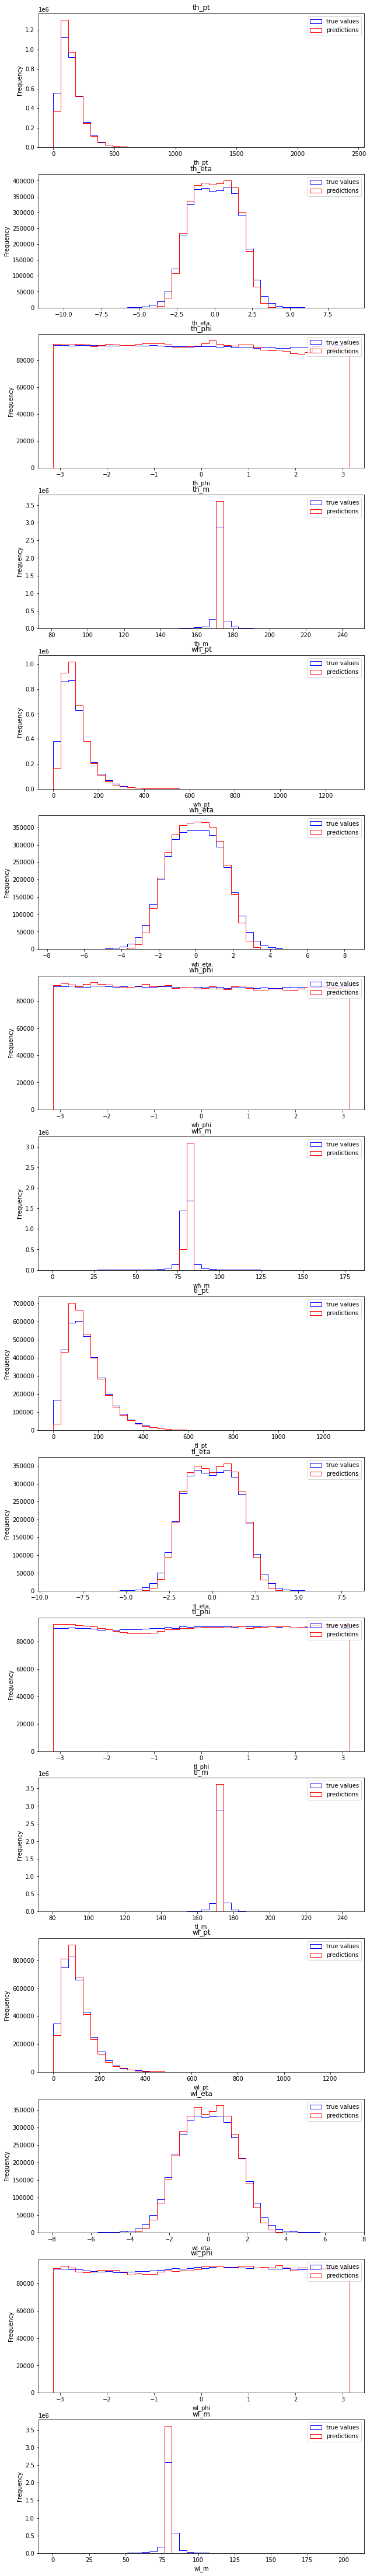

In [23]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


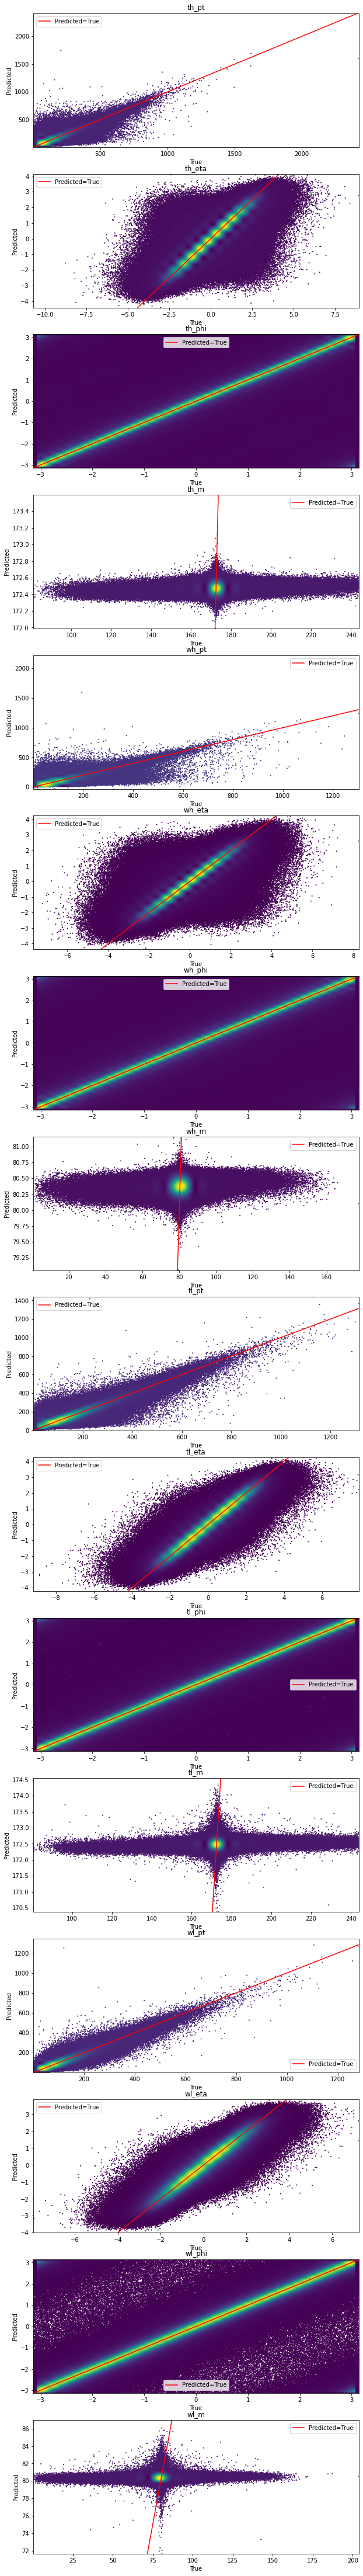

In [24]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

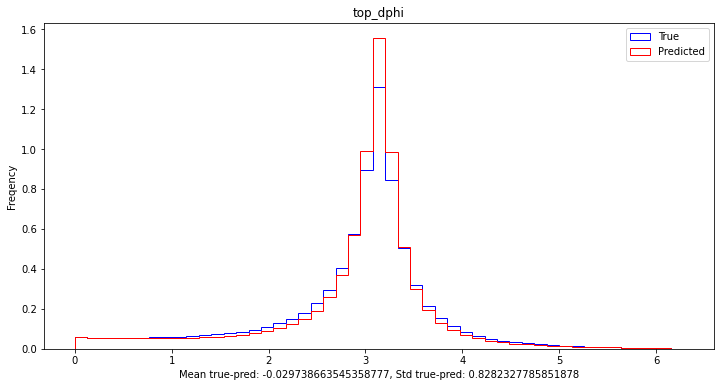

In [25]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

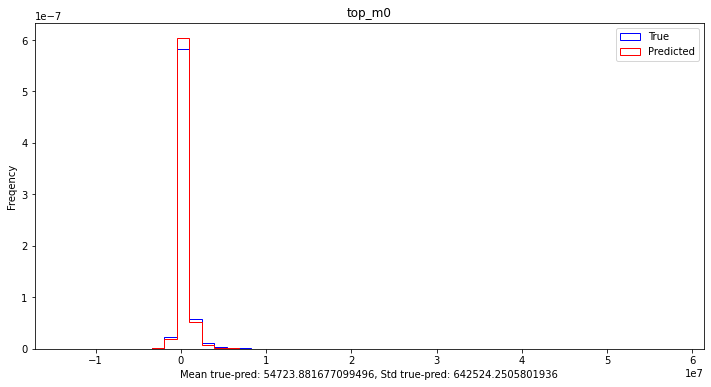

In [26]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

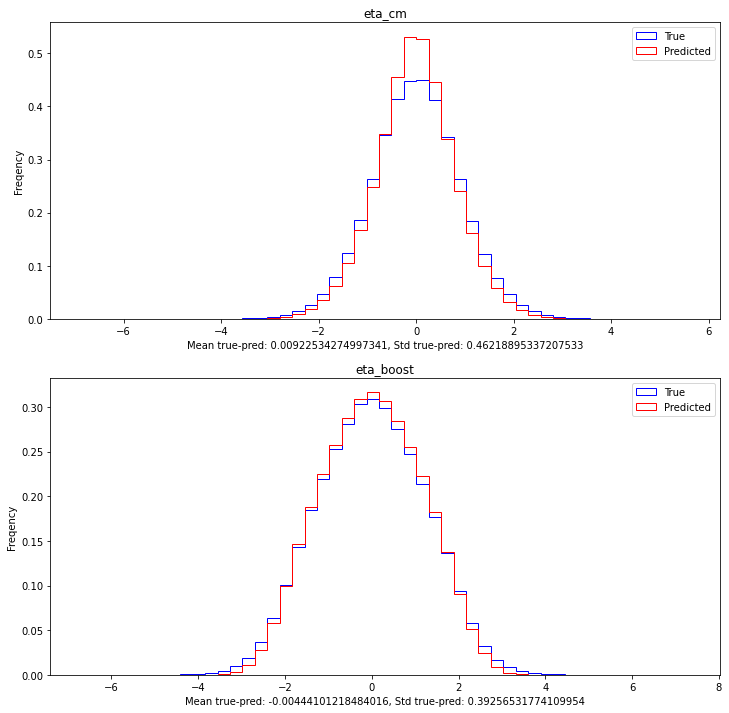

In [27]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

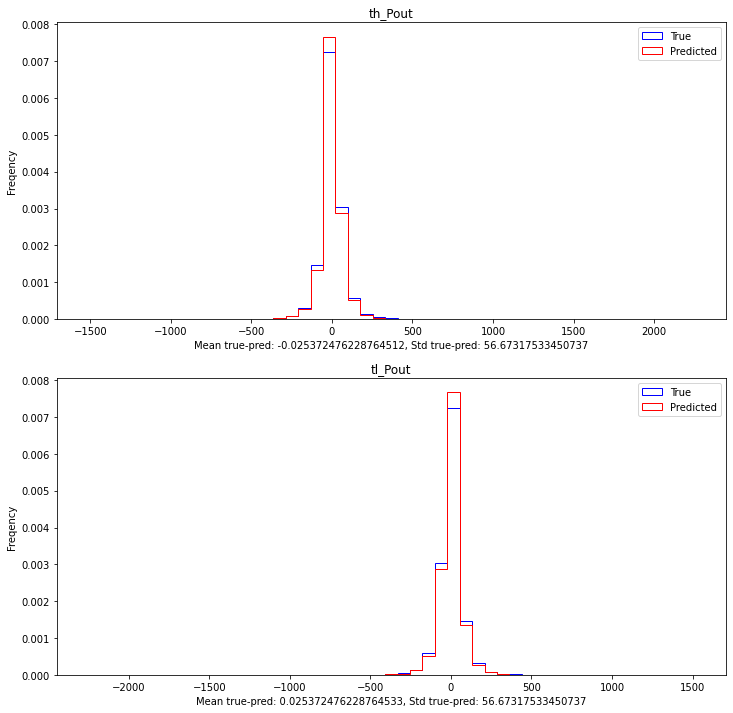

In [28]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

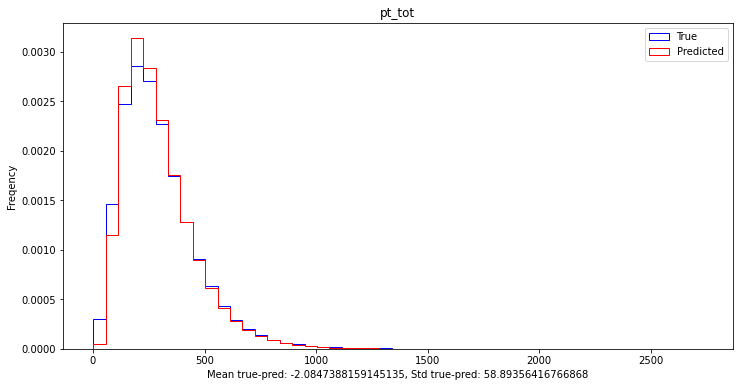

In [29]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])